In [1]:
%load_ext autoreload
%autoreload 2
from fastai import *
from fastai.text import * 
from fastai.callbacks import *
import pandas as pd
import json
import pathlib
import sklearn
from sklearn import model_selection
import numpy as np
import html

In [2]:
LM_PATH=Path('../../models/ulmfit/lm/tweets-en')
DATA_PATH=Path('../../data/twitter-en/vocab')
LM_PATH.mkdir(exist_ok=True)

In [3]:
# See how many devices are around
print('Devices available: ', torch.cuda.device_count())
# Set it to a particular device
CUDA_DEVICE = 7
print('Set device: ', CUDA_DEVICE)
torch.cuda.set_device(CUDA_DEVICE)
# Check which device you are on
print('Current device: ', torch.cuda.current_device())

Devices available:  8
Set device:  7
Current device:  7


In [4]:
VOCAB_DATASET = os.path.join(DATA_PATH, 'merged.txt')

In [5]:
def read_data(filename):
    data = pd.read_csv(filename, sep="|", names =['utterance'], header=None, dtype={'utterance':str} )
    return data

In [6]:
LANG_TEXT = read_data(VOCAB_DATASET).dropna()


In [7]:
LANG_TEXT.head()

,utterance
0,one crowded hour of glorious life is worth an ...
1,username blame mike brown
2,dr michael brown's guitar collection auctione...
3,interview me
4,username anyway seeing as i've got british ci...


In [8]:
LANG_TEXT.shape

(5326166, 1)

In [9]:
LANG_TEXT['utterance'].apply(lambda x: len(x.split(" "))).sum()

104757466

In [10]:
(LANG_TEXT.to_csv(f"{DATA_PATH}/tweets_EN_Corpus.csv", columns=["utterance"], header=None, index=False))

In [11]:
txt_proc = [
    TokenizeProcessor(tokenizer=Tokenizer(lang='en') ),
    NumericalizeProcessor(min_freq=3, max_vocab=30000 )
]

In [12]:
data_lm = (TextList
           .from_csv(DATA_PATH, 'tweets_EN_Corpus.csv', cols=0, processor=txt_proc)
           #Where are the text? Column 'text' of texts.csv
           .split_by_rand_pct()
           #How to split it? Randomly with the default 20% in valid
           .label_for_lm()
           #Label it for a language model
           .databunch(num_workers=5))
           #Finally we convert to a DataBunch

/usr/local/lib/python3.6/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


In [13]:
len(data_lm.train_ds.vocab.itos)

30000

In [14]:
data_lm.show_batch()

/usr/local/lib/python3.6/dist-packages/fastai/text/data.py:339: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  idx_min = (t != self.pad_idx).nonzero().min()


idx,text
0,michael brown xxbos of course username bo xxrep 4 y it look like sea view farm and all saints belong to michael brown xxbos oh what a tangled web we weave when first we practice to deceive sir walter scott xxbos username lost set them 130 they got it with a few overs and two xxunk to spare mike brown 30 odd xxunk 20 odd jon xxunk 4 fer xxbos
1,it zora neale hurston mikebrown xxbos wtf username ferguson police shoots unarmed black kid 10 times xxbos must read ferguson justiceformikebrown a story of michael brown xxbos username another child dead for what xxunk mikebrown fergusonshooting xxbos username i do n't know enough about ferguson yet to judge but yes bad cop work often results in confrontation where none is needed xxbos holy shit username jesus ferguson quiktrip burning xxbos
2,away from the vigil ferguson xxbos the police murdered mike brown the police lied about it the police sent militarized forces to a candlelight vigil xxbos the major military equipment we are seeing on us streets driven by police was first used to destroy civilians in other co xxbos right now in ferguson xxunk xxunk this is terrifying xxbos at 18 mikebrown is referred to as a man in the
3,xxbos how is a majority a minority ferguson xxbos username you are missing a big story ferguson we need independent media network fail xxbos justice for palestine mikebrown ericgarner treyvonmartin oscargrant marissaalexander jordandavis xxunk xxbos blacks are twice as likely to be stopped as whites even though police find contraband for 34 of whites vs 22 of blacks xxbos crazy witness speaks on the murder of mike brown new video
4,say officer who killed mike brown suffered facial injuries in the incident h xxbos shits getting crazy in ferguson xxbos username i want to get this tattooed on my back ferguson literally the dopest picture i 've ever seen xxbos sigh i interviewed the key witness to the michael brown shooting last night the police haven t think about that xxbos username username indeed i pray for justice in ferguson


In [15]:
data_lm.save("tweets_en_data_lm_30k")

In [16]:
len(data_lm.vocab.stoi)

378285

In [17]:
data_lm = load_data(DATA_PATH, "tweets_en_data_lm_30k")

In [18]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0, pretrained=False, callback_fns=ShowGraph)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


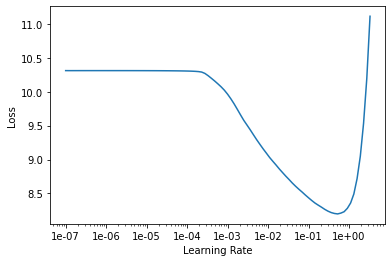

In [19]:
learn.lr_find()
learn.recorder.plot(skip_start=0)

epoch,train_loss,valid_loss,accuracy,time
0,4.269163,4.267437,0.291917,50:17
1,4.353350,4.349190,0.282552,50:16
2,4.358390,4.369827,0.279981,50:35
3,4.326471,4.333348,0.284264,50:17
4,4.338665,4.317756,0.285450,50:09
5,4.209753,4.213745,0.296657,50:04
6,4.104716,4.090505,0.310779,50:06
7,3.966971,3.965539,0.326274,52:28
8,3.837365,3.862427,0.340066,58:30
9,3.758412,3.828835,0.345330,1:05:32


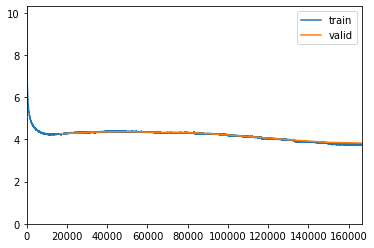

Better model found at epoch 0 with valid_loss value: 4.267436981201172.
Better model found at epoch 5 with valid_loss value: 4.213744640350342.
Better model found at epoch 6 with valid_loss value: 4.090505123138428.
Better model found at epoch 7 with valid_loss value: 3.96553897857666.
Better model found at epoch 8 with valid_loss value: 3.8624274730682373.
Better model found at epoch 9 with valid_loss value: 3.8288347721099854.


In [20]:
learn.fit_one_cycle(10, 2e-2, moms=(0.8,0.7), callbacks=[ShowGraph(learn), SaveModelCallback(learn, name='tweets-en-25k-lm-head-best')])

In [21]:
learn.load("tweets-en-25k-lm-head-best")

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (4260932 items)
x: LMTextList
xxbos username blame mike brown,xxbos dr michael brown 's guitar collection xxunk off see pics gt,xxbos interview me,xxbos username anyway seeing as i 've got british citizenship now i 'm waiting for my call up reckon i can give mike brown some competition,xxbos nowplaying the biggest hits with nothing but the 90s with mike brown xxunk
y: LMLabelList
,,,,
Path: ../../data/twitter-en/vocab;

Valid: LabelList (1065233 items)
x: LMTextList
xxbos republicans say all lives matter when it comes to abortion but silent when it comes to a black boy killed in the streets ferguson,xxbos brown family attorney tells username news they have been notified that grand jury has reached decision in ferguson,xxbos if you are outside the yellow line when this starts you are going to jail officer to reporters ferguson username they 're about to go in,xxbos all of these warnings telling people 2 peacefully protest make me t

In [22]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(5, 2e-3, moms=(0.8,0.7), callbacks=[ShowGraph(learn), SaveModelCallback(learn, name='tweets-en-30k-lm-step2-best')])

epoch,train_loss,valid_loss,accuracy,time


In [ ]:
learn.load('tweets-en-30k-lm-step2-best')

In [ ]:
learn.fit_one_cycle(1, 7e-4, moms=(0.8,0.7), callbacks=[ShowGraph(learn), SaveModelCallback(learn, name='tweets-en-30k-lm-step3-best')])

In [ ]:
np.exp(2.583128)

In [ ]:
learn.fit_one_cycle(4, 7e-4, moms=(0.8,0.7), callbacks=[ShowGraph(learn), SaveModelCallback(learn, name='tweets-en-30k-lm-step4-best')])

In [ ]:
learn.load('tweets-en-30k-lm-step4-best')

In [ ]:
learn.save_encoder('tweets_en_lm_30k_encoder')

In [ ]:
learn.export('tweets_en_lm_30k_export')

In [ ]:
data_lm.vocab.save(pathlib.Path(f"{DATA_PATH}/tweets_en_lm_30k_itos_vocab.pkl"))